# Task 2: Covid-19 Rumour Analysis
This notebook is for covid-19 rumour analysis. The analysis incoudes "data distribution", "hashtag analysis", "user information analysis", and "semantic analysis" on both the source tweets and reply tweets of rumour and non-rumour events.

In [1]:
import json
from collections import Counter
import re
import numpy as np
import pandas as pd
import pickle
from IPython.display import display

In [2]:
covid_data = []
dev_data = []
train_data = []
'''
The read jsonl file will be a list of list of dict.
List of events, each events is a list of tweets.
Each tweet is a dict, contain information about that tweet.
'''
with open('drive/MyDrive/NLP_Pro1/covid.data.jsonl') as f:
    for line in f:
        covid_data.append(json.loads(line))
with open('drive/MyDrive/NLP_Pro1/dev.data.jsonl') as f:
    for line in f:
        dev_data.append(json.loads(line))
with open('drive/MyDrive/NLP_Pro1/train.data.jsonl') as f:
    for line in f:
        train_data.append(json.loads(line))

In [13]:
#%% read the predicted covid label
covid_label = json.load(open('drive/MyDrive/NLP_Pro1/covid-output.json')) #read as a dict
train_label = json.load(open('drive/MyDrive/NLP_Pro1/train.label.json')) #read as a dict
dev_label = json.load(open('drive/MyDrive/NLP_Pro1/dev.label.json')) #read as a dict

In [14]:
#%% convert the tweet event data to simple dataframe
'''
Input:
    data: a list of list of dict, which is from the original read jsonl file
        (a list of event, each event is a list of tweets, 
         each tweets is a dict that contain information about that dict)
    label: a dict
Output: a dataframe, which contain the text of event, the eventID, and the Label
Label: 0 means non-rumour, 1 means rumour, 3 means label not provided
'''
def dataToDf(data,label):
    data_dict = {}
    eventTexts = [] #To save the text of all events 
    eventIds = [] #To save the Id of all events
    for event in data:  #every event is a list of dict
        eventText = '' #To save the text from all tweets of a event
        eventId = event[0]['id_str'] #first tweet of an event is the source tweet, take out its ID
    
        for tweet in event: #first tweet is the source tweet #tweet is a dict
            tempText = re.sub("@[\S]*[\s]?", "", tweet['text']).strip() #remove mention@
            #tempText = re.sub("#[\S]*[\s]?", "hashtag", tempText) #remove hashtag
            eventText = eventText +' [SEP] '+tempText.lower()
        eventText = eventText + ' [SEP]'
        eventText=eventText.strip()
        eventText=eventText.split(' ', 1)[1] #remove the first word '[SEP]'
        eventText = '[CLS]'+' '+eventText
        #print(eventText)
        eventTexts.append(eventText)
        eventIds.append(eventId)
    data_dict['eventID'] = eventIds
    data_dict['eventTexts'] = eventTexts
    data_dict['label'] = 3
    tempDf = pd.DataFrame(data = data_dict)

    if label != None:
        for key in label.keys():
            tempDf.loc[tempDf['eventID']==key,'label'] = label[key]
        tempDf['label']=tempDf['label'].apply(lambda x: 1 if x=='rumour' else 0)
    return tempDf

In [15]:
#%% Generate the dataframe
df_covid = dataToDf(covid_data, covid_label)
df_dev = dataToDf(dev_data,dev_label)
df_train = dataToDf(train_data, train_label)

In [16]:
#%% This function plots the number of reply tweets distribution
'''
Input:
    data: a list of list of dict
        (a list of event, each event is a list of tweets, 
         each tweets is a dict that contain information about that dict)
    title: a string, the title of the plot
'''
import matplotlib.pyplot as plt
def plotReply(data,title):
    noOfReply = []
    for event in data:
        noOfReply.append(len(event)-1)
    #plt.rcParams["figure.dpi"]=600
    #b = np.arange(0,max(noOfReply),1)
    b = np.arange(0,200,1)
    plt.hist(noOfReply, bins = b, rwidth=0.9)
    plt.xlabel("Number of Replied Tweet in Each Event")
    plt.ylabel("Event Count")
    plt.title(title)
    plt.show()
    print("There are average {} reply tweets.".format(sum(noOfReply)/len(noOfReply)))

In [17]:
'''
This function seperate the rumours and non-rumours from the original Twitter data
Input:
    data: a list of list of dict
        (a list of event, each event is a list of tweets, 
         each tweets is a dict that contain information about that dict)
    label: a dict
'''
def extractRumour(data, label):
    rumour_list = []
    non_rumour_list = []
    #df_rumour = pd.DataFrame()
    for event in data:
        eventID = event[0]['id_str']
        if label[eventID] == "rumour":
            rumour_list.append(event)
        else:
            non_rumour_list.append(event)
    return rumour_list, non_rumour_list

covid_rumour_list, covid_non_rumour_list = extractRumour(covid_data, covid_label)

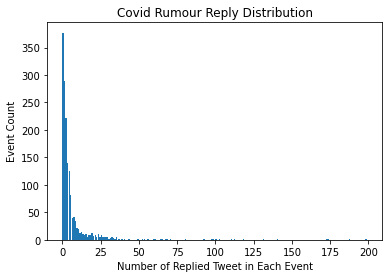

There are average 7.629241209130167 reply tweets.


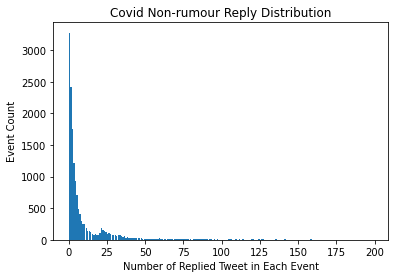

There are average 14.19814358780072 reply tweets.


In [18]:
#%% plot the number of reply distribution of covid rumour and non-rumour
plotReply(covid_rumour_list,"Covid Rumour Reply Distribution")
plotReply(covid_non_rumour_list, "Covid Non-rumour Reply Distribution")

In [19]:
#%% Hashtag Analysis
'''
This function extract the hashtags from the data. It can be used to extract only the source tweet or the reply tweets
Input:
    data: a list of list of dict
        (a list of event, each event is a list of tweets, 
         each tweets is a dict that contain information about that dict)
    reply: boolean, if true, this function will also count the reply tweets,
        if false, it will only count the source tweets
Return:
    a counter that count the freq of hashtags in the dataset
'''
from collections import Counter
def collectHashtag(data, reply):
    hashtags_list = []
    for event in data:
        if reply:
            for tweet in event:
                for hashtags in tweet.get('entities').get('hashtags'):
                    hashtags_list.append(hashtags['text'])
        else:
            for hashtags in event[0].get('entities').get('hashtags'):
                hashtags_list.append(hashtags['text'])
    hashtags_list_c = Counter()
    for tag in hashtags_list:
        hashtags_list_c[tag] += 1
    
    return hashtags_list_c

'''
This function plot the freq distribution of top N hashtag in the dataset
Input:
    counter: dictionary, the hashtags
    n: int, how many most frequent hashtags to extract
    title: string, the title of the plot
'''
def plotTopHashtag(counter, n, title):
    topNDict_rumour = {}
    
    for pair in counter.most_common(n):
        topNDict_rumour[pair[0]] = (pair[1] / sum(counter.values()))
    #plt.close('all')
    plt.bar(topNDict_rumour.keys(), topNDict_rumour.values())
    plt.title(title)
    plt.xticks(rotation=90,fontsize=7)

Text(0.5, 1.0, 'Rumour vs Non-Rumour in all Tweets')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


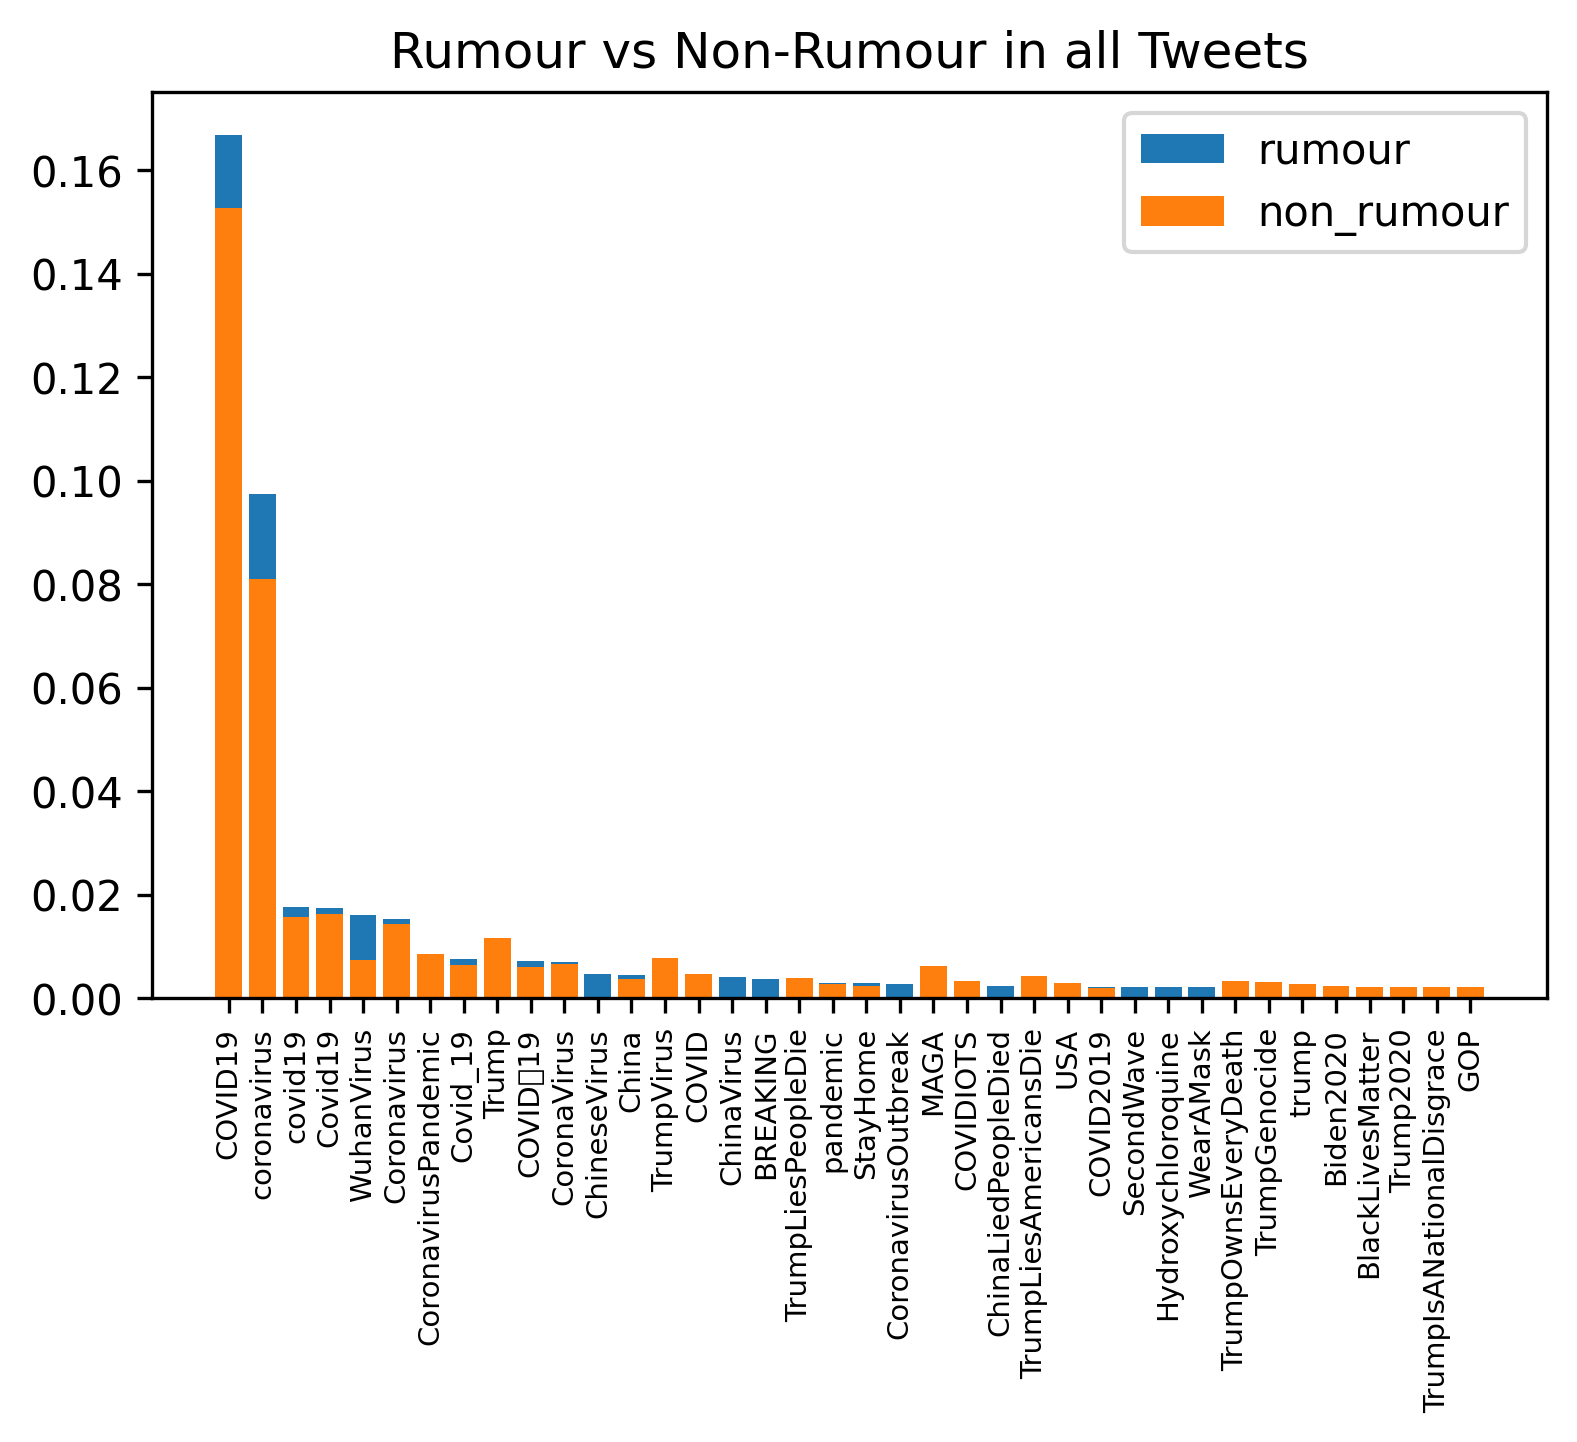

In [23]:
rumour_hashtags = collectHashtag(covid_rumour_list, True)
non_rumour_hashtags = collectHashtag(covid_non_rumour_list, True)

plt.close('all')
plt.rcParams["figure.dpi"]=300
plotTopHashtag(rumour_hashtags, 30, "HashTags of Rumour - Top30")
plotTopHashtag(non_rumour_hashtags, 30, "HashTags of Non-Rumour - Top30")
plt.legend(('rumour','non_rumour'), loc='best')
plt.title("Rumour vs Non-Rumour in all Tweets")

Text(0.5, 1.0, 'Rumour vs Non-Rumour in source Tweets')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


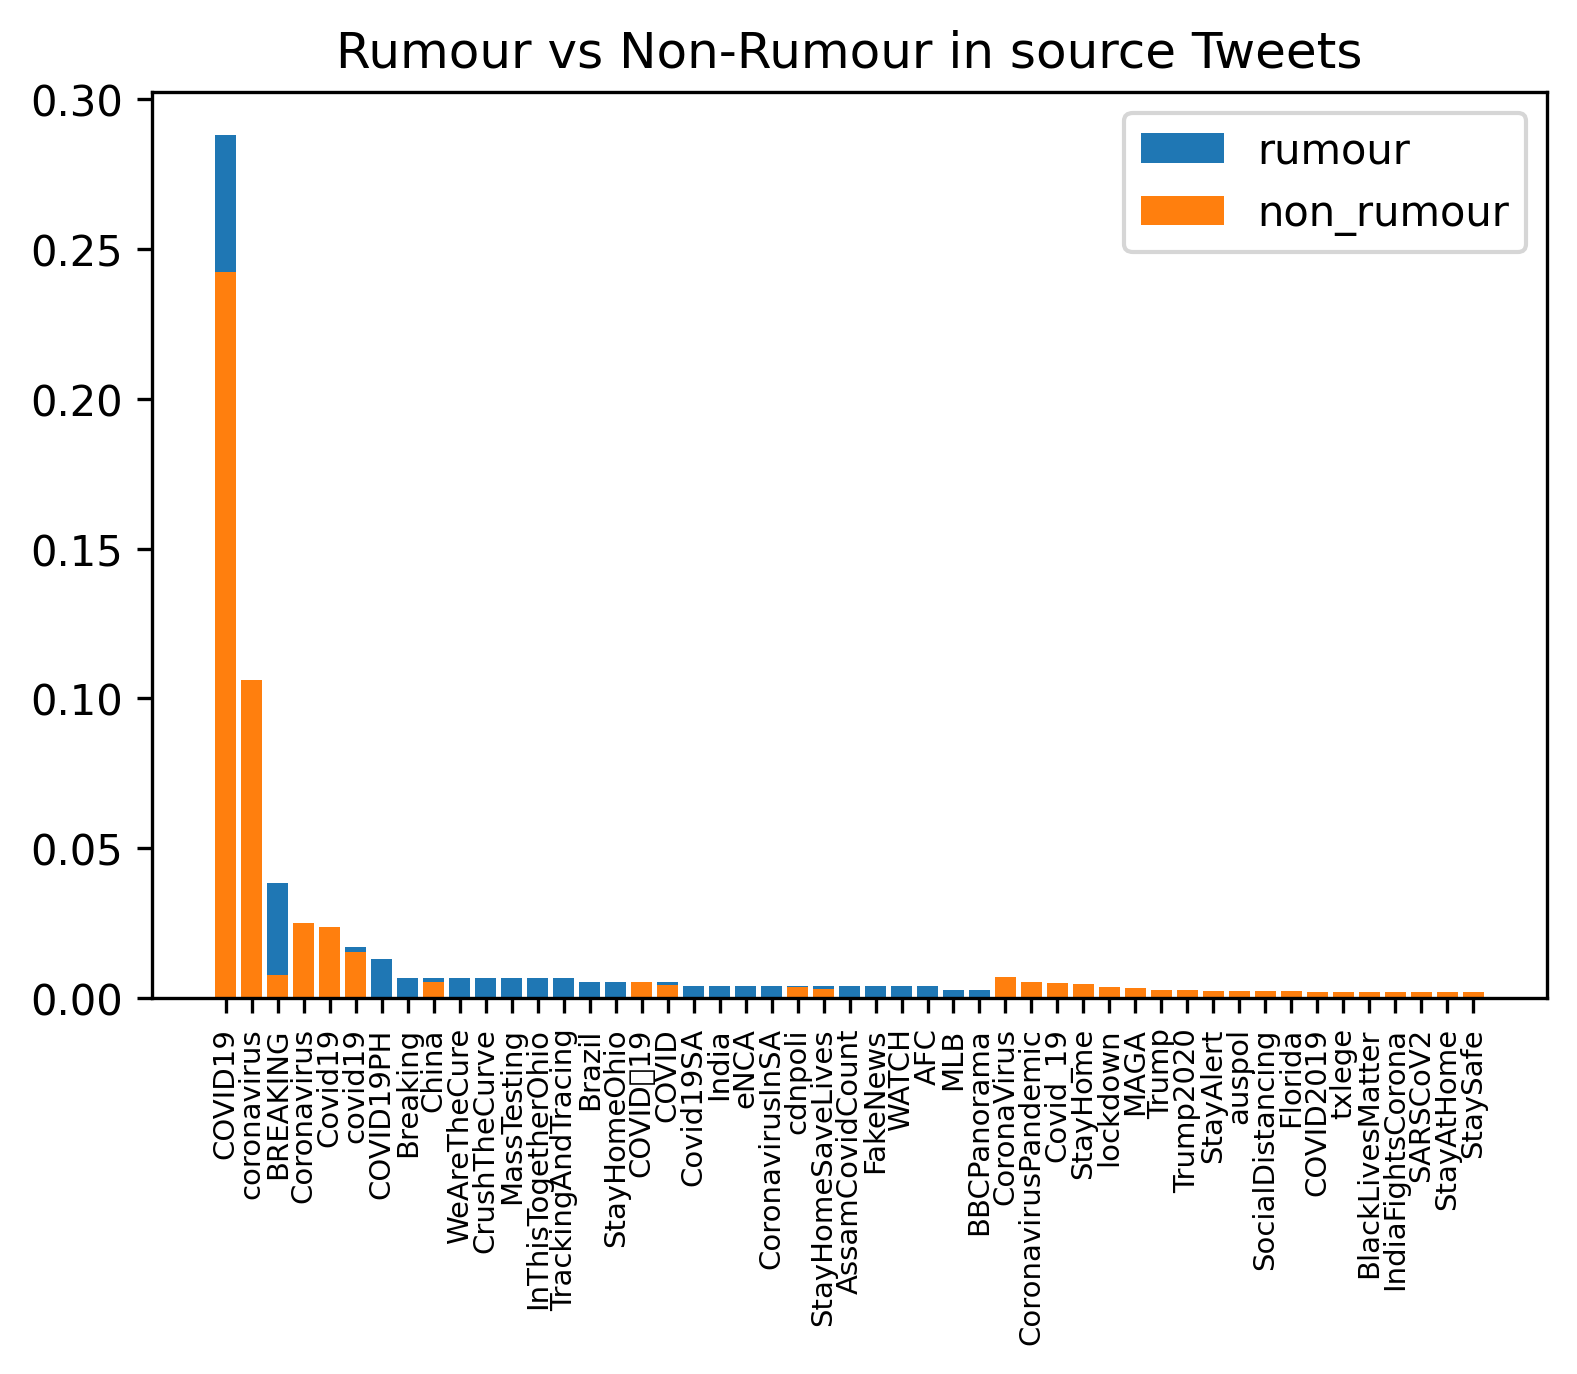

In [22]:
rumour_hashtags = collectHashtag(covid_rumour_list, False)
non_rumour_hashtags = collectHashtag(covid_non_rumour_list, False)

plt.close('all')
plt.rcParams["figure.dpi"]=300
plotTopHashtag(rumour_hashtags, 30, "HashTags of Rumour - Top30")
plotTopHashtag(non_rumour_hashtags, 30, "HashTags of Non-Rumour - Top30")
plt.legend(('rumour','non_rumour'), loc='best')
plt.title("Rumour vs Non-Rumour in source Tweets")

In [12]:
#%% Count how many URL are contains in one event
def countURL(data):
    url_list = []
    for event in data:
        for tweet in event:
            for url in tweet.get('entities').get('urls'):
                url_list.append(url)
    urlRatio = len(url_list) / len(data)
    return urlRatio

rumour_url_ratio = countURL(covid_rumour_list)
non_rumour_url_ratio = countURL(covid_non_rumour_list)
print("On average, a rumour evenr contains {} URL, while a non-rumour event contains {} URL".format(rumour_url_ratio,non_rumour_url_ratio))


On average, a rumour tweet contains 1.6512013256006628 URL, while a non-rumour tweet contains 2.96092548150883 URL


In [13]:
#%% analyse the information of source user
from datetime import datetime
def sourceUser(data):
    isVerified = 0
    followers_count = 0
    friends_count = 0
    listed_count = 0
    statuses_count = 0
    created_at = 0 #UTC datetime
    hasImage = 0
    
    for event in data:
        user = event[0].get('user') #only analysis the source user
        if user.get('verified'):
            isVerified += 1
        if not(user.get('default_profile_image')):
            hasImage += 1
        followers_count += user.get('followers_count')
        friends_count += user.get('friends_count')
        listed_count += user.get('listed_count')
        statuses_count += user.get('statuses_count')
        created_at += int((user.get('created_at').split())[-1]) #the year that the account created
    isVerified = isVerified/len(data)
    followers_count = followers_count/len(data)
    friends_count = friends_count/len(data)
    listed_count = listed_count/len(data)
    statuses_count = statuses_count/len(data)
    hasImage = hasImage/len(data)
    created_at = created_at/len(data)
    
    tempDict = {}
    tempDict['isVerified']=isVerified
    tempDict['followers_count']=followers_count
    tempDict['friends_count']=friends_count
    tempDict['listed_count']=listed_count
    tempDict['statuses_count']=statuses_count
    tempDict['hasImage']=hasImage
    tempDict['created_at']=created_at
    return tempDict

rumour_user_analysis = sourceUser(covid_rumour_list)
non_rumour_user_analysis = sourceUser(covid_non_rumour_list)  
display(rumour_user_analysis)
display(non_rumour_user_analysis)

{'created_at': 2010.7464788732395,
 'followers_count': 4144885.8591549294,
 'friends_count': 6678.577464788732,
 'hasImage': 0.9991714995857498,
 'isVerified': 0.7622203811101905,
 'listed_count': 13815.710024855012,
 'statuses_count': 139433.24192212097}

{'created_at': 2010.8827764445266,
 'followers_count': 5441753.300658421,
 'friends_count': 7953.084364039136,
 'hasImage': 0.9999384653252108,
 'isVerified': 0.7421081779582794,
 'listed_count': 15572.755091994339,
 'statuses_count': 114295.95280290443}

In [18]:
!pip install stanza

In [21]:
import stanza
stanza.download('en')

2021-05-13 15:04:16 INFO: Downloading default packages for language: en (English)...
2021-05-13 15:05:39 INFO: Finished downloading models and saved to /root/stanza_resources.


In [31]:
'''
This function analysis the sentiment of each senstences in the data.
negative, neutral, and positive, represented by 0, 1, 2 
Input:
    data: a list of list of dict
    reply: bollean, if false, then only analyse the source tweets. if true, also analyse the reply tweets.
'''
import stanza
def semanticAnalisis(data,reply):
    negative = 0
    neutral = 0
    positive = 0
    nlp = stanza.Pipeline(lang='en', processors='tokenize,sentiment')        
    for event in data:
        if reply:
            for tweet in event:
                doc = nlp(tweet.get('text'))
                for i, sentence in enumerate(doc.sentences):
                    #print(i, sentence.sentiment)
                    if sentence.sentiment == 0:
                        negative += 1
                    elif sentence.sentiment == 1:
                        neutral += 1
                    else:
                        positive += 1
        else:
            tweet = event[0] #take out the source tweets
            doc = nlp(tweet.get('text'))
            for i, sentence in enumerate(doc.sentences):
                #print(i, sentence.sentiment)
                if sentence.sentiment == 0:
                    negative += 1
                elif sentence.sentiment == 1:
                    neutral += 1
                else:
                    positive += 1

    return negative, neutral, positive

In [32]:
sNeg, sNeu, sPos = semanticAnalisis(covid_rumour_list, False)
sTotal = sNeg+sNeu+sPos
print("There are {} negative, {} neutral, {} positive sentences in the source tweets of rumour".format(sNeg/sTotal, sNeu/sTotal, sPos/sTotal))

sNeg, sNeu, sPos = semanticAnalisis(covid_non_rumour_list, False)
sTotal = sNeg+sNeu+sPos
print("There are {} negative, {} neutral, {} positive sentences in the source tweets of non-rumour".format(sNeg/sTotal, sNeu/sTotal, sPos/sTotal))

sNeg, sNeu, sPos = semanticAnalisis(covid_rumour_list, True)
sTotal = sNeg+sNeu+sPos
print("There are {} negative, {} neutral, {} positive sentences in all tweets of rumour".format(sNeg/sTotal, sNeu/sTotal, sPos/sTotal))

sNeg, sNeu, sPos = semanticAnalisis(covid_non_rumour_list, True)
sTotal = sNeg+sNeu+sPos
print("There are {} negative, {} neutral, {} positive sentences in all tweets of non-rumour".format(sNeg/sTotal, sNeu/sTotal, sPos/sTotal))

2021-05-13 15:19:25 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-05-13 15:19:25 INFO: Use device: cpu
2021-05-13 15:19:25 INFO: Loading: tokenize
2021-05-13 15:19:25 INFO: Loading: sentiment
2021-05-13 15:19:26 INFO: Done loading processors!
2021-05-13 15:20:52 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-05-13 15:20:52 INFO: Use device: cpu
2021-05-13 15:20:52 INFO: Loading: tokenize
2021-05-13 15:20:52 INFO: Loading: sentiment


There are 0.3069936421435059 negative, 0.638813200121102 neutral, 0.054193157735392065 positive sentences in the source tweets of rumour


2021-05-13 15:20:53 INFO: Done loading processors!
2021-05-13 15:40:49 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-05-13 15:40:49 INFO: Use device: cpu
2021-05-13 15:40:49 INFO: Loading: tokenize
2021-05-13 15:40:49 INFO: Loading: sentiment


There are 0.29673401118006953 negative, 0.6379462124213213 neutral, 0.0653197763986091 positive sentences in the source tweets of non-rumour


2021-05-13 15:40:50 INFO: Done loading processors!
2021-05-13 15:52:36 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-05-13 15:52:36 INFO: Use device: cpu
2021-05-13 15:52:36 INFO: Loading: tokenize
2021-05-13 15:52:36 INFO: Loading: sentiment


There are 0.3010837798343887 negative, 0.6509376522162689 neutral, 0.047978567949342424 positive sentences in all tweets of rumour


2021-05-13 15:52:37 INFO: Done loading processors!


There are 0.2993375691668558 negative, 0.6513685000610937 neutral, 0.04929393077205048 positive sentences in all tweets of non-rumour
